Yea we train in Jupyter now, deal with it.

In [1]:
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from torch.utils.data import WeightedRandomSampler

from assembly_extract import OPS_LENGTH

import random

import networkx as nx
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GATv2Conv

C:\Users\tanas\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_graph(G, color = None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos = nx.spring_layout(G, seed = 42), with_labels = False,
                     node_size = 32, node_color = color, cmap = "Set2", alpha = 0.5)
    plt.show()


def visualize_embedding(h, color = None, epoch = None, loss = None):
    plt.figure(figsize = (7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s = 140, cmap = "Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize = 16)
    plt.show()

In [16]:
dataset = torch.load('data/dataset16N.pt')
random.shuffle(dataset)

print(f"Amount of items: {len(dataset)}")

bn = 0
rs = 0

for d in dataset:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1

print(f"Amount of ransomware: {rs}")
print(f"Amount of benign: {bn}")

data_len = len(dataset)
train_amo = round(data_len * 0.8)

train_data = dataset[:train_amo]
test_data = dataset[train_amo:]

bn = 0
rs = 0

for d in train_data:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1
        
class_weight = [1 / bn, 1 / rs]
sample_weight = torch.from_numpy(np.array([class_weight[data.y] for data in train_data]))
train_sampler = WeightedRandomSampler(sample_weight.type(torch.DoubleTensor), len(sample_weight))

train_loader = DataLoader(train_data, batch_size=64, sampler = train_sampler)

Amount of items: 6980
Amount of ransomware: 5001
Amount of benign: 1979


In [39]:
rs = 0
bn = 0
test_data = []

for d in dataset:
    if d.y.item() == 1 and rs < 1000:
        rs += 1
        test_data.append(d)
    elif d.y.item() == 0 and bn < 1000:
        bn += 1
        test_data.append(d)

test_loader = DataLoader(test_data, batch_size=64, shuffle = False)

In [17]:
from torch_geometric.utils import to_networkx

print(f'Number of graphs: {len(dataset)}')

nodes = []
for d in dataset:
    nodes.append(d.x.shape[0])
    
nodes = np.array(nodes)
nodes_avg = np.mean(nodes)
nodes_sd  = np.std(nodes)

print(f"Avg nodes count: {nodes_avg:.2f}")
print(f"Avg nodes sd: {nodes_sd:.2f}")

Number of graphs: 6980
Avg nodes count: 11008.85
Avg nodes sd: 27661.78


In [ ]:
# data = dataset[10:100]
# for i, d in enumerate(data):
#     print(f"{i}: {d.x.shape}")

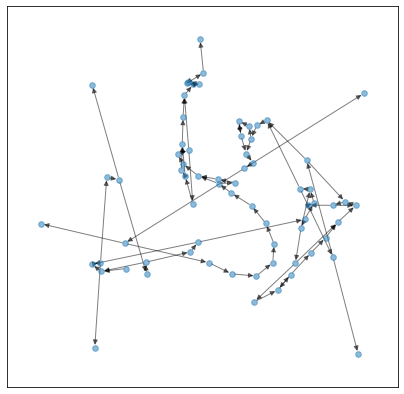

In [6]:
# G = to_networkx(data[4], to_undirected = False)
# visualize_graph(G)

In [26]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, embed_dim = 16):
        super(GCN, self).__init__()
        
        self.embed = nn.Embedding(OPS_LENGTH, embed_dim)
        self.conv1 = GCNConv(OPS_LENGTH, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.lin = nn.Linear(hidden_channels, 2)
        self.lin = nn.Sequential(
            nn.Linear(hidden_channels, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 2)
        ) 

    def forward(self, x, edge_index, batch):
        #print(f"input shape : {x.shape}")
        #print(f"edge shape : {edge_index.shape}")
        #x = self.embed(x)
        
        #print(f"embeded shape : {x.shape}")
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [12]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(OPS_LENGTH, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATv2Conv(hidden_channels * 2, hidden_channels)
        # self.lin = nn.Sequential(
        #     nn.Linear(hidden_channels, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 2),
        #     nn.Sigmoid(),
        # ) 
        
        self.lin1 = nn.Linear(hidden_channels, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, 2)
        #self.lin3 = nn.Linear(64, 32)
        #self.lin4 = nn.Linear(32, 2)
        
        self.bng = nn.BatchNorm1d(hidden_channels)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        #self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p = 0.5, training = self.training)
        x = self.bng(x)
        #print(f"GMP = {x.shape}")

        x = self.lin1(x)
        x = x.relu()
        x = self.bn1(x)        
        #print(f"x1 = {x.shape}")

        x = self.lin2(x)
        x = x.relu()
        x = self.bn2(x)        
        #print(f"x2 = {x.shape}")

        x = self.lin3(x)
        x = x.relu()
        #print(f"x3 = {x.shape}")
        #x = self.bn3(x)
        
        #print(f"x4 = {x}")
        #x = self.lin4(x)
        #x = x.relu()
        
        
        return x

In [44]:
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCH = 10
embed_dim = 1260
lr = 1e-4

# latent_dim = 64
# WEIGHT_PATH = "data/weightGCN.pt"
# model = GCN(hidden_channels = latent_dim, embed_dim = embed_dim)

latent_dim = 32
WEIGHT_PATH = "data/weightGAT2.pt"
model = GAT(hidden_channels = latent_dim)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

print(model)
model.load_state_dict(torch.load(WEIGHT_PATH))

GAT(
  (conv1): GATv2Conv(16, 32, heads=1)
  (conv2): GATv2Conv(32, 64, heads=1)
  (conv3): GATv2Conv(64, 32, heads=1)
  (lin1): Linear(in_features=32, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=2, bias=True)
  (bng): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


<All keys matched successfully>

In [37]:
from torchmetrics import ConfusionMatrix

f1 = []
acc = []
best = 0

def test():
    model.eval()

    Apred = []
    Atarg = []
    
    for data in test_loader:  
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim = 1)  
        
        Apred.append(pred)
        Atarg.append(data.y)
        
    Apred = torch.concat(Apred)
    Atarg = torch.concat(Atarg)
    
    confmat = ConfusionMatrix(num_classes = 2)
    conf = confmat(Apred, Atarg).numpy()
    
    test_f1 = conf[0][0] / (conf[0][0] + 1/2 * (conf[0][1] + conf[1][0]))
    test_acc = (conf[0][0] + conf[1][1]) / (conf[0][0] + conf[0][1] + conf[1][0] + conf[1][1])
    
    f1.append(test_f1)
    acc.append(test_acc)
    
    return test_f1, test_acc

In [46]:
test_f1, test_acc = test()
print(f'Test F1: {test_f1:.4f}, Test acc: {test_acc:.4f}')

Test F1: 0.8361, Test acc: 0.8320


100%|██████████| 88/88 [20:00<00:00, 13.65s/it]


Epoch: 001, Test F1: 0.8161, Test acc: 0.8150


100%|██████████| 88/88 [17:26<00:00, 11.89s/it]


Epoch: 002, Test F1: 0.8219, Test acc: 0.8210


100%|██████████| 88/88 [16:22<00:00, 11.16s/it]


Epoch: 003, Test F1: 0.8318, Test acc: 0.8255


100%|██████████| 88/88 [16:36<00:00, 11.32s/it]


Epoch: 004, Test F1: 0.8278, Test acc: 0.8255


100%|██████████| 88/88 [16:51<00:00, 11.49s/it]


Epoch: 005, Test F1: 0.8296, Test acc: 0.8240


100%|██████████| 88/88 [17:07<00:00, 11.68s/it]


Epoch: 006, Test F1: 0.8236, Test acc: 0.8225


100%|██████████| 88/88 [16:41<00:00, 11.38s/it]


Epoch: 007, Test F1: 0.8327, Test acc: 0.8300


100%|██████████| 88/88 [16:15<00:00, 11.08s/it]


Epoch: 008, Test F1: 0.8258, Test acc: 0.8255


100%|██████████| 88/88 [16:46<00:00, 11.44s/it]


Epoch: 009, Test F1: 0.8286, Test acc: 0.8285


100%|██████████| 88/88 [16:54<00:00, 11.53s/it]


Epoch: 010, Test F1: 0.8361, Test acc: 0.8320


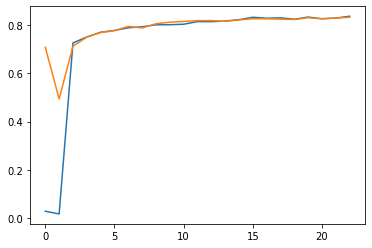

In [45]:
def train():
    model.train()
    test_loop = 0

    for data in tqdm(train_loader):
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad()  
        
        #test_loop += 1
        #if test_loop >= 20:
            #test_loop = 0
            #test()

for e in range(EPOCH):
    train()
    test_f1, test_acc = test()
    
    if test_f1 > best:
        best = test_f1
        torch.save(model.state_dict(), WEIGHT_PATH)
    
    print(f'Epoch: {e+1:03d}, Test F1: {test_f1:.4f}, Test acc: {test_acc:.4f}')

plt.plot(f1)
plt.plot(acc)
plt.show()

## Load & Inference

In [ ]:
WEIGHT_PATH = "data/weightGAT2.pt"
latent_dim = 32
inference_model = GAT(hidden_channels = latent_dim)
inference_model.load_state_dict(torch.load(WEIGHT_PATH))
inference_model.eval()
print(inference_model)

GAT(
  (conv1): GATv2Conv(16, 32, heads=1)
  (conv2): GATv2Conv(32, 64, heads=1)
  (conv3): GATv2Conv(64, 32, heads=1)
  (lin1): Linear(in_features=32, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=2, bias=True)
  (bng): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
from dismgrp import dismgrp
from torch.nn.functional import softmax

def isRansom(path):
    try:
        data = dismgrp(path)
    except Exception as e:
        raise e
    
    with torch.no_grad():
        res = inference_model(data.x, data.edge_index, data.batch)
        res = res[0]
    
    pre = torch.argmax(res).item()
    sm = softmax(res, dim = 0)
    #print(f"\t{data.x[0] = }")
    #print(f"\t{res = }")
    #print(f"\t{sm = }")
    prob = sm[pre].item() * 100
    return pre, prob

In [ ]:
import os

p = "D:/Work/SIIT/4th year/1 - 2022/CSS453 Cyber crime/project/pe/benign/"
i = 0
lst = os.listdir(p)
for f in lst[i : i + 500 : 10]:
    pth = p + f
    stat = os.stat(pth)
    if stat.st_size > 2 ** 20 * 5:
        continue
    print(f"Scanning {f}...")
    try:
        pre, prob = isRansom(pth)
        res = "Ransom" if pre == 1 else "Safe"
        print(f"\tResult: {prob:.0f}% {res}")
    except Exception as e:
        print(f"\tError, " + str(e))

Scanning 106.0.5249.119_106.0.5249.103_chrome_updater.exe...
	Result: 91% Safe
Scanning AAM Updates Notifier.exe...
	Result: 55% Ransom
Scanning aarch64-linux-android-dwp.exe...
	Error, Error decompiling file: Empty result
Scanning aarch64-linux-android-size.exe...
	Error, Error decompiling file: Empty result
Scanning AcrobatNotificationClient.exe...
	Result: 56% Ransom
Scanning activate_matlab.exe...
	Result: 80% Ransom
Scanning ADelRCP.exe...
	Result: 65% Ransom
Scanning AdobeGenuineValidator.exe...
	Result: 53% Safe
Scanning adobe_licensing_wf.exe...
	Result: 95% Safe
Scanning AdvancedParticles.exe...
	Result: 96% Ransom
Scanning Ahk2Exe.exe...
	Result: 78% Ransom
Scanning al.exe...
	Result: 72% Safe
Scanning AppHostRegistrationVerifier.exe...
	Result: 94% Safe
Scanning appvcleaner.exe...
	Result: 81% Safe
Scanning ar.exe...
	Error, Error decompiling file: Empty result
Scanning arm-linux-androideabi-gprof.exe...
	Error, Error decompiling file: Empty result
Scanning arm-linux-android

In [ ]:
pre, prob = isRansom("D:/Work/SIIT/4th year/1 - 2022/CSS453 Cyber crime/project/pe/benign/7z.exe")
res = "Ransom" if pre == 1 else "Safe"
print(f"{prob:.0f}% {res}")

81% Safe
